# CAICT 風機結冰預測 - Data Sampling

2017/07/12  
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

## 1. 題目簡介

### **Load Data and Modules**

**Load Python modules:**

In [220]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import pandas as pd
import os
import sys
from PIL import Image
import numpy as np
import lzma
import pickle
from IPython.display import display
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
import shutil
import csv
import sklearn as sk
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pylab import *
from IPython.core.interactiveshell import InteractiveShell
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"


In [260]:

def timerangeCheck(t, start, end):
    return (t>=start) & (t<=end)
        
def updateProgress(msg):
    sys.stdout.write('\r')
    sys.stdout.write(msg)
    sys.stdout.flush()
    
def myscore(true_y, pred_y):
    n,p =sk.metrics.confusion_matrix(train_y, train_pred)
    tn = n[0]
    fp = n[1]
    fn = p[0]
    tp = p[1]
    #print('tn:',tn,'fp:',fp,'fn:',fn,'fp:',fp)
    score = 1- 0.5*(fp/(tn+fp))- 0.5*(fn/(fn+tp)) 
    #print('score',score)
    return score, {'tn':tn,'fp':fp,'fn':fn,'tp':tp}

def event_info(data, event_id):
    dummy = plt.figure(figsize=[17,2])
    print('event:',event_id)
    evtdata = data[data['event']==event_id]
    evtdata_nor=evtdata[evtdata['label']==0]
    evtdata_abnor=evtdata[evtdata['label']==1]
    evtdata_unknown=evtdata[evtdata['label']==2]
    nor_min = ((evtdata_nor['time'].iloc[-1] - evtdata_nor['time'].iloc[0]).total_seconds())/60
    abnor_min = ((evtdata_abnor['time'].iloc[-1] - evtdata_abnor['time'].iloc[0]).total_seconds())/60
    unknown_min = 0 if evtdata_unknown.empty else ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60    
    event_msg = pd.DataFrame({'type':['normal','unknown','abnormal']})
    event_msg['minute']=[nor_min,unknown_min,abnor_min]
    event_msg['hour']=[nor_min/60,unknown_min/60,abnor_min/60]
    print(event_msg)

    dummy=plt.plot(evtdata_nor['timestamp'],evtdata_nor['label'],label='normal', color='green',marker='o')
    dummy=plt.plot(evtdata_abnor['timestamp'],evtdata_abnor['label'],label='abnormal', color='red',marker='o')
    dummy=plt.plot(evtdata_unknown['timestamp'],evtdata_unknown['label'],label='unknown', color='gray',marker='o')
    dummy=plt.legend()
    dummy =plt.ylim(-1,3)
    dummy=plt.show()

    dummy = plt.figure(figsize=[17,2])
    dummy=plt.plot(evtdata['timestamp'],evtdata['label'],label='event'+str(event_id), color='blue', marker='o')
    dummy=plt.legend()
    dummy =plt.ylim(-1,3)
    dummy=plt.show()
    return event_msg

def assign_eventid(data):
    label_col = data['label']
    label_col = label_col.values
    event_end=False
    event_id = 0;
    label_previous=0
    event_id_col = []
    for label in label_col: 
        if (label==0) & (label_previous==1):
            event_end=True
        label_previous = label;
        if event_end:
            event_end=False
            event_id=event_id+1
        event_id_col.append(event_id)    
    data['event']=event_id_col
    return data

def events_summary(data):
    events_info = pd.DataFrame(columns=('eventid', 'nor_min','unknown_min', 'abnor_min', 'nor_cnt', 'unknown_cnt', 'abnor_cnt','nor_idx_start','nor_idx_end','unknown_idx_start','abnor_idx_start', 'abnor_idx_end','no_unknown'))
    for eventid in set(data['event']):
        data_event = data[data['event']==eventid]
        evtdata_nor=data_event[data_event['label']==0]
        evtdata_abnor=data_event[data_event['label']==1]
        evtdata_unknown=data_event[data_event['label']==2]

        nor_min = ((evtdata_nor['time'].iloc[-1] - evtdata_nor['time'].iloc[0]).total_seconds())/60
        abnor_min = ((evtdata_abnor['time'].iloc[-1] - evtdata_abnor['time'].iloc[0]).total_seconds())/60
        #unknown_min = ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60
        unknown_min = 0 if evtdata_unknown.empty else ((evtdata_unknown['time'].iloc[-1] - evtdata_unknown['time'].iloc[0]).total_seconds())/60    
        event_cnt = data_event['event'].count()
        nor_cnt = evtdata_nor['event'].count()
        abnor_cnt = evtdata_abnor['event'].count()
        #unknown_cnt= evtdata_unknown['event'].count()
        unknown_cnt = 0 if evtdata_unknown.empty else evtdata_unknown['event'].count()

        nor_idx_start= evtdata_nor.index[0]
        nor_idx_end= evtdata_nor.index[-1]
        
        abnor_idx_start= evtdata_abnor.index[0]
        abnor_idx_end= evtdata_abnor.index[-1]
        unknown_idx_start= abnor_idx_start if evtdata_unknown.empty else evtdata_unknown.index[0]

        no_known= 'Y' if evtdata_unknown.empty else 'N'
        events_info.loc[eventid] = [eventid, nor_min, unknown_min, abnor_min, nor_cnt, unknown_cnt, abnor_cnt,nor_idx_start,nor_idx_end, unknown_idx_start, abnor_idx_start, abnor_idx_end,no_known]
    return events_info

def resample_info(events_info):
    resample_info = pd.DataFrame(columns=('eventid', 'abnor_cnt','event_start', 'event_end'))
    for idx, row in events_summary_15.iterrows():
        event_id = row['eventid']
        abnor_cnt = row['abnor_cnt']
        event_start = row['nor_idx_end'] - abnor_cnt
        event_end = row['abnor_idx_end'] + abnor_cnt
        resample_info.loc[event_id] = [event_id, abnor_cnt, event_start, event_end]
    return resample_info

**Load input data.** 

In [143]:
#%run -i 'load_data.py'
data_15 = pd.read_csv('data/goodformat_15.csv')
data_21 = pd.read_csv('data/goodformat_21.csv')
data_test = pd.read_csv('data/ice1/test/08/08_data.csv')

data_15 = data_15.fillna(2)
data_21 = data_21.fillna(2)


** change time format from string to datetime**

In [222]:
data_15['time']=pd.to_datetime(data_15['time'])
data_21['time']=pd.to_datetime(data_21['time'])
data_test['time']=pd.to_datetime(data_test['time'])

data_15['timestamp'] = data_15['time'].apply(lambda x: x.timestamp())
data_21['timestamp'] = data_21['time'].apply(lambda x: x.timestamp())
data_test['timestamp'] = data_test['time'].apply(lambda x: x.timestamp())

** assign event id**

In [223]:
data_15 = assign_eventid(data_15)
data_21 = assign_eventid(data_21)

** events summary **

In [241]:
events_summary_15 = events_summary(data_15)
events_summary_15

,eventid,nor_min,unknown_min,abnor_min,nor_cnt,unknown_cnt,abnor_cnt,nor_idx_start,nor_idx_end,unknown_idx_start,abnor_idx_start,abnor_idx_end,no_unknown
0,0,4206.0,1237.0,52.0,5727,860,443,0,5840,4756,6587,7029,N
1,1,5258.0,119.0,112.0,43020,372,265,7030,50049,50050,50422,50686,N
2,2,413.0,118.0,113.0,3383,1000,951,50687,54069,54070,55070,56020,N
3,3,8579.0,637.0,737.0,39486,1114,2101,56021,95506,95507,95621,98721,N
4,4,4978.0,16.0,13.0,35032,139,106,98722,133753,133754,133893,133998,N
5,5,2140.0,27.0,41.0,14016,230,352,133999,148014,148015,148245,148596,N
6,6,297.0,1478.0,3294.0,2120,2349,3188,148597,150716,150717,151717,156253,N
7,7,3799.0,118.0,113.0,29550,1000,951,156254,185803,185804,186804,187754,N
8,8,154.0,162.0,800.0,1321,1031,1254,187755,189075,189076,190107,191360,N
9,9,399.0,0.0,17.0,3212,0,148,191361,194572,194573,194573,194720,Y


** each event of original data**

event: 0
       type  minute       hour
0    normal  5259.0  87.650000
1   unknown  1237.0  20.616667
2  abnormal    52.0   0.866667


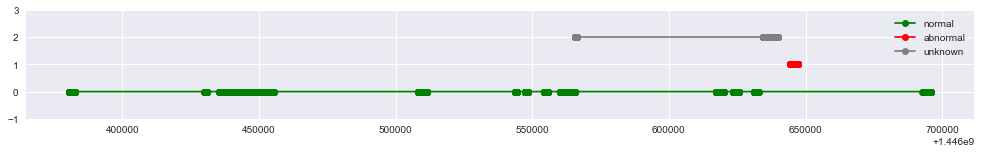

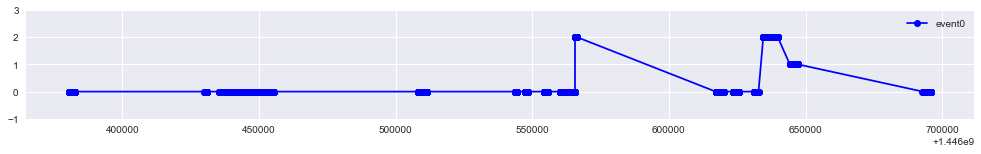

event: 1
       type  minute       hour
0    normal  5822.0  97.033333
1   unknown   119.0   1.983333
2  abnormal   112.0   1.866667


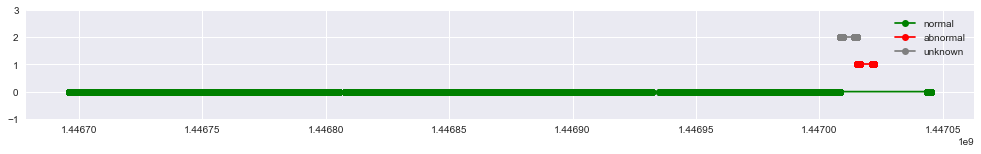

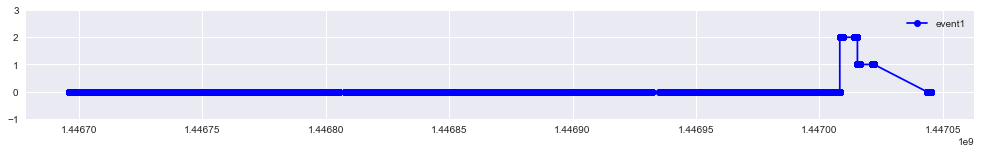

event: 2
       type  minute       hour
0    normal  1461.0  24.350000
1   unknown   118.0   1.966667
2  abnormal   113.0   1.883333


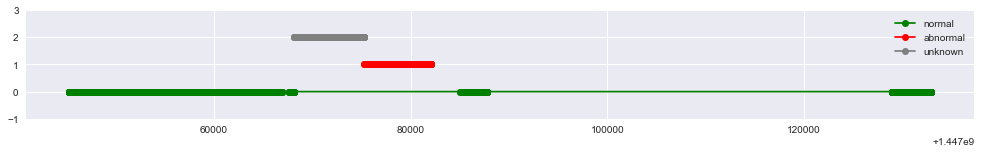

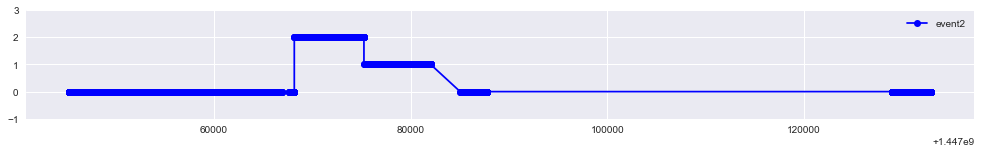

event: 3
       type   minute        hour
0    normal  10225.0  170.416667
1   unknown    637.0   10.616667
2  abnormal    737.0   12.283333


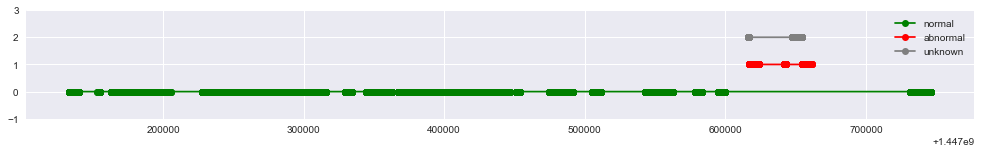

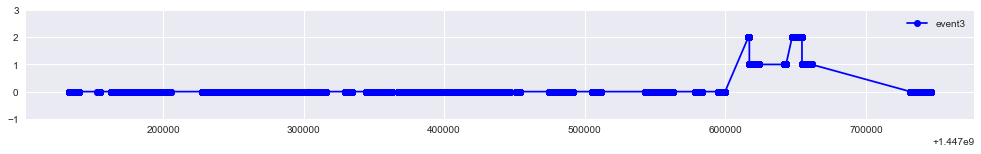

event: 4
       type  minute       hour
0    normal  5496.0  91.600000
1   unknown    16.0   0.266667
2  abnormal    13.0   0.216667


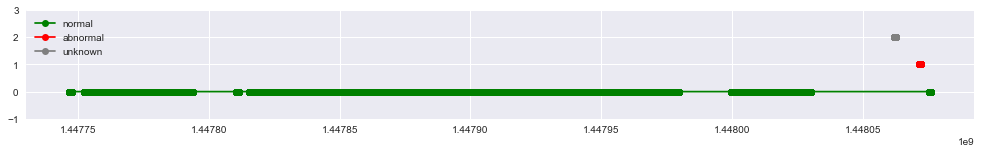

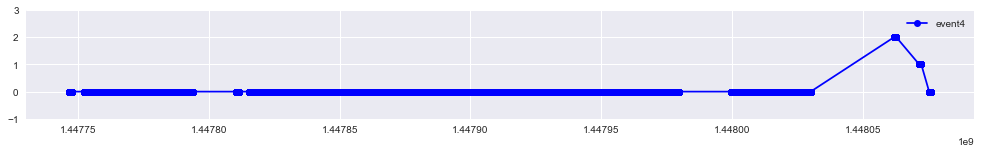

event: 5


IndexError: single positional indexer is out-of-bounds

In [297]:
for eventid in set(data_15['event']):
    dummy = event_info(data_15,eventid)

** define balanced data set **

In [247]:
resample_info_15 = resample_info(events_summary_15)

In [248]:
resample_info_15

,eventid,abnor_cnt,event_start,event_end
0,0,443,5397,7472
1,1,265,49784,50951
2,2,951,53118,56971
3,3,2101,93405,100822
4,4,106,133647,134104
5,5,352,147662,148948
6,6,3188,147528,159441
7,7,951,184852,188705
8,8,1254,187821,192614
9,9,148,194424,194868


** resample **

In [294]:
data = data_15
resample_data_15 = pd.DataFrame()
for idx, row in resample_info_15.iterrows():
    event_id = row['eventid']
    abnor_cnt = row['abnor_cnt']
    event_start = row['event_start']
    event_end = row['event_end']
    resample_data_i = data[event_start:event_end]
    resample_data_i['event']=event_id
    resample_data_15 =resample_data_15.append(resample_data_i)
    

instance/import.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [301]:
resample_data_15.to_csv('data/resample_data_15.csv')

** each event of resample data**

event: 0
       type  minute       hour
0    normal  1196.0  19.933333
1   unknown    89.0   1.483333
2  abnormal    52.0   0.866667


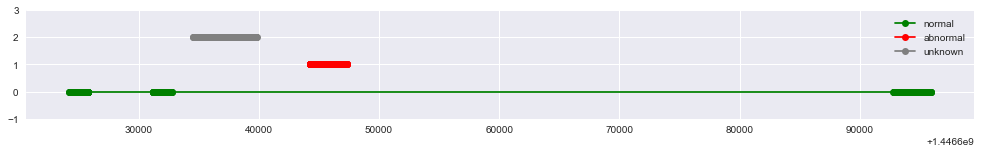

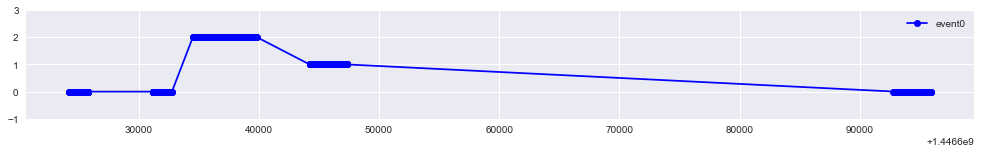

event: 1
       type  minute       hour
0    normal   660.0  11.000000
1   unknown   119.0   1.983333
2  abnormal   112.0   1.866667


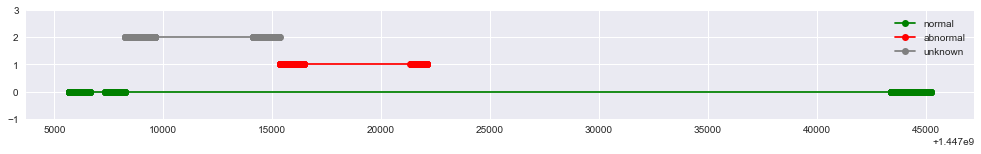

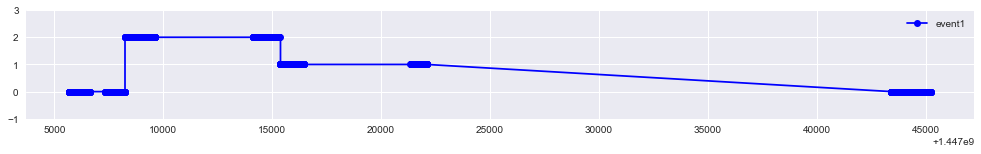

event: 2
       type  minute       hour
0    normal  1203.0  20.050000
1   unknown   118.0   1.966667
2  abnormal   113.0   1.883333


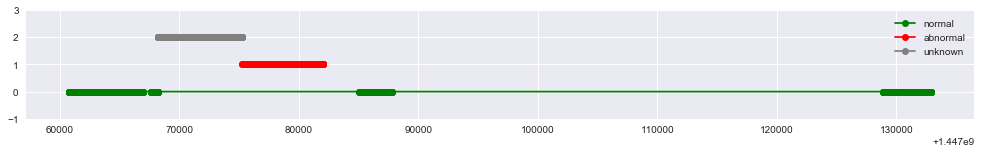

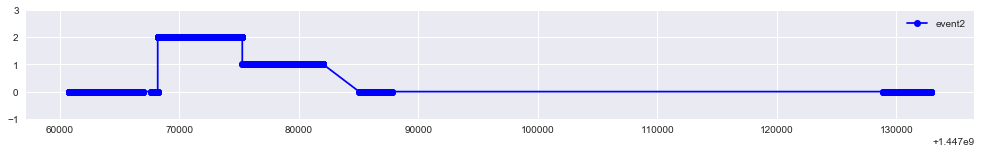

event: 3
       type  minute       hour
0    normal  3183.0  53.050000
1   unknown   637.0  10.616667
2  abnormal   737.0  12.283333


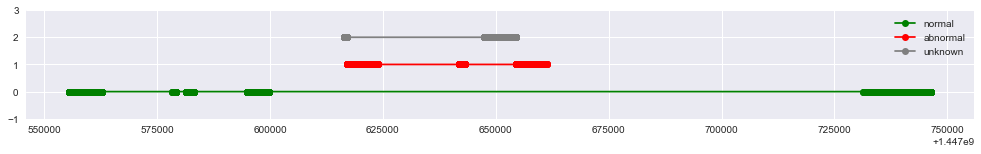

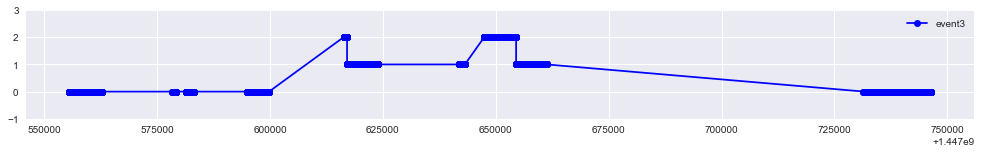

event: 4
       type  minute       hour
0    normal   780.0  13.000000
1   unknown    16.0   0.266667
2  abnormal    13.0   0.216667


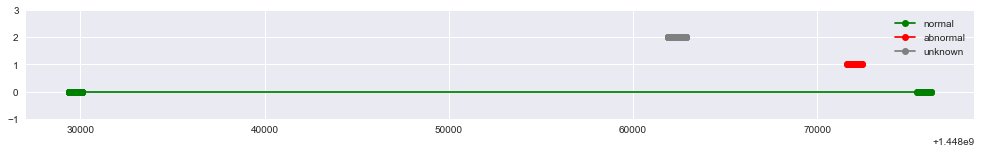

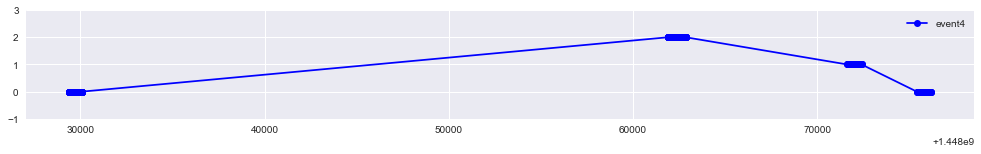

event: 5
       type  minute       hour
0    normal   875.0  14.583333
1   unknown    27.0   0.450000
2  abnormal    41.0   0.683333


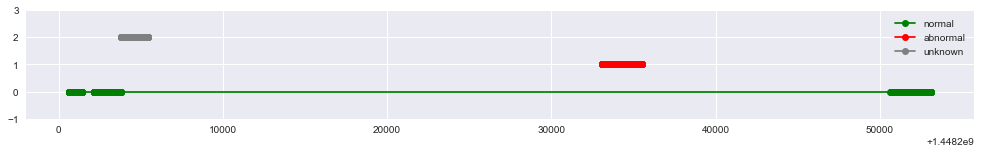

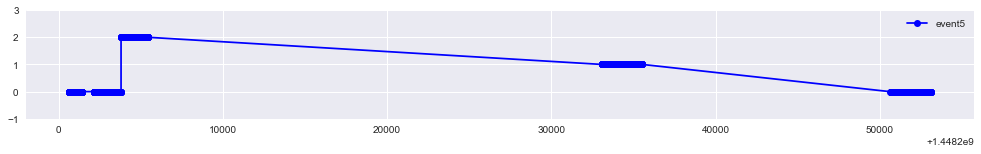

event: 6
       type  minute       hour
0    normal  5362.0  89.366667
1   unknown  2556.0  42.600000
2  abnormal  4002.0  66.700000


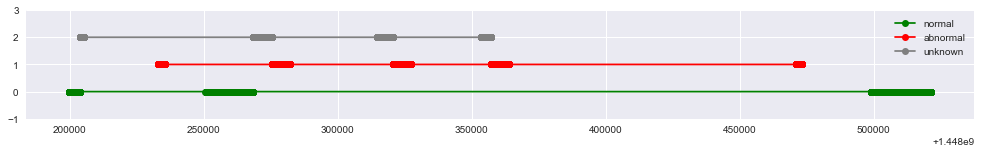

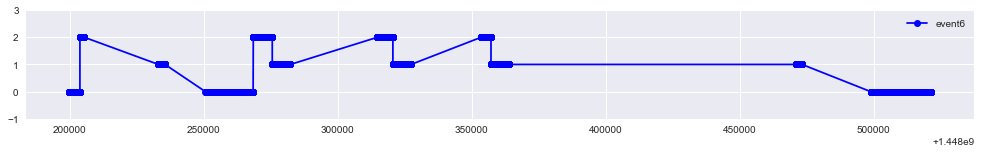

event: 7
       type  minute       hour
0    normal   927.0  15.450000
1   unknown   118.0   1.966667
2  abnormal   113.0   1.883333


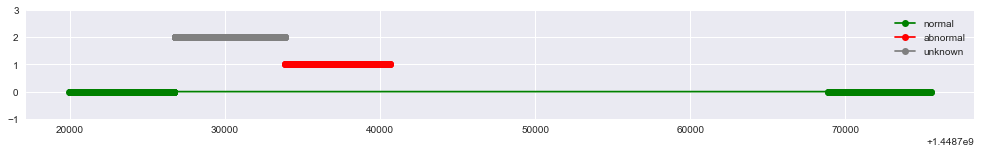

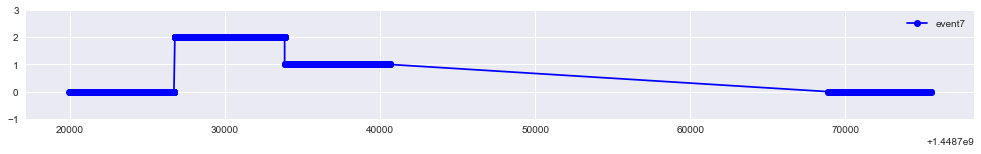

event: 8
       type  minute       hour
0    normal  1480.0  24.666667
1   unknown   162.0   2.700000
2  abnormal   800.0  13.333333


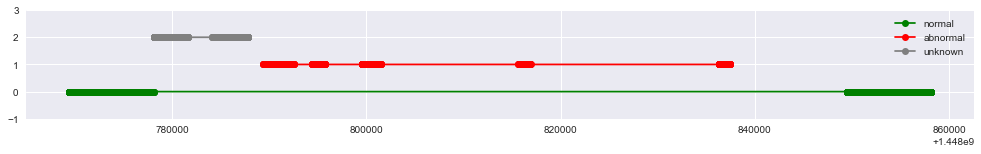

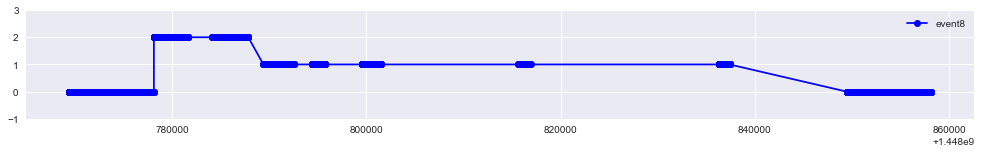

event: 9
       type  minute       hour
0    normal  1274.0  21.233333
1   unknown     0.0   0.000000
2  abnormal    17.0   0.283333


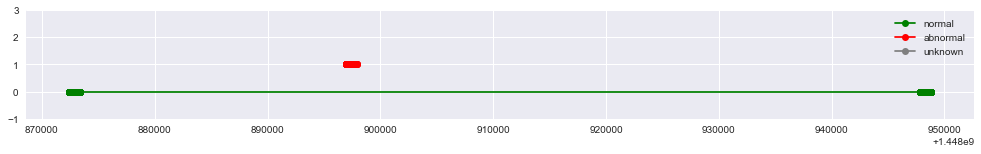

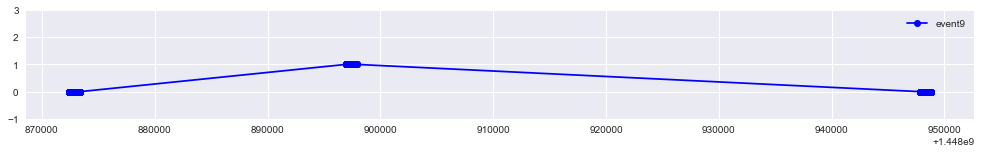

event: 10
       type  minute       hour
0    normal   654.0  10.900000
1   unknown   116.0   1.933333
2  abnormal   111.0   1.850000


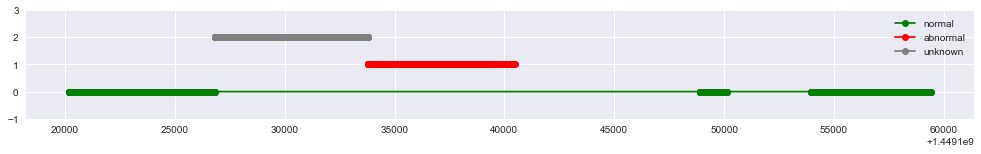

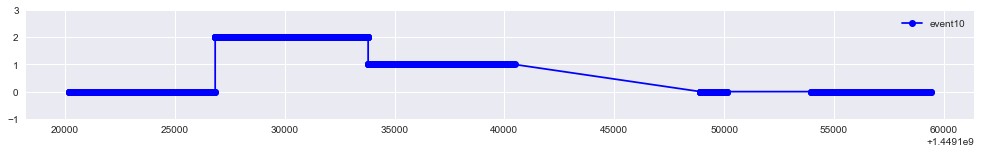

event: 11
       type  minute       hour
0    normal  1313.0  21.883333
1   unknown   105.0   1.750000
2  abnormal   193.0   3.216667


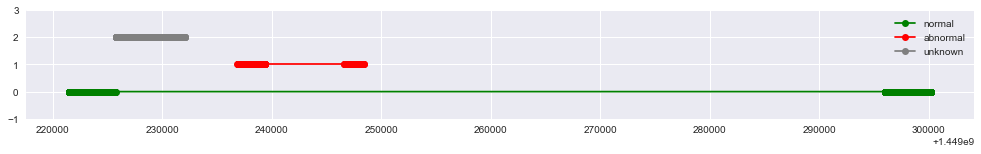

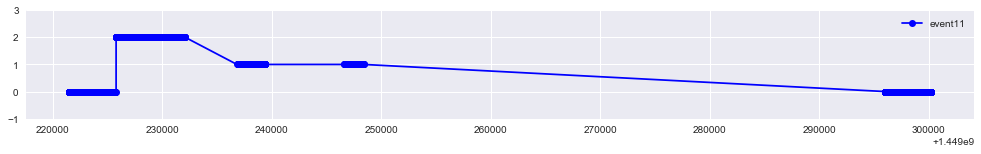

event: 12
       type  minute       hour
0    normal  1490.0  24.833333
1   unknown   116.0   1.933333
2  abnormal  1251.0  20.850000


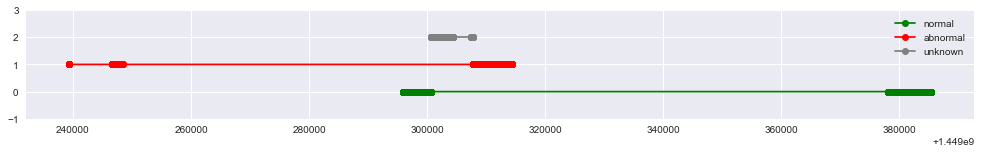

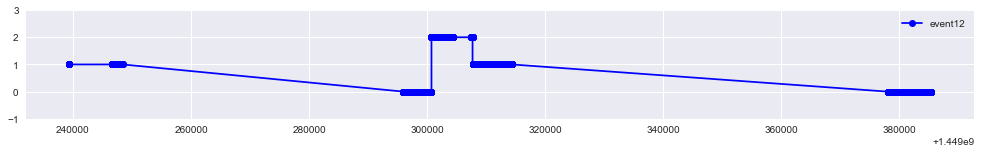

event: 13
       type  minute       hour
0    normal  2900.0  48.333333
1   unknown  1703.0  28.383333
2  abnormal  1717.0  28.616667


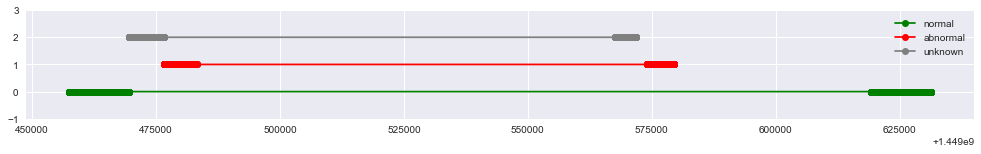

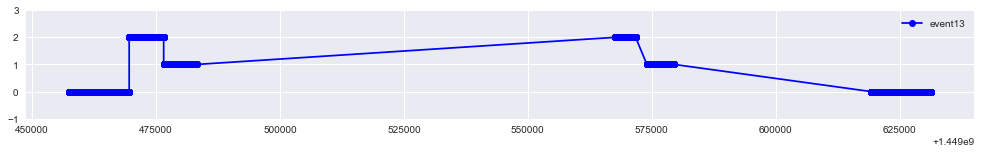

event: 14
       type  minute       hour
0    normal  1278.0  21.300000
1   unknown   116.0   1.933333
2  abnormal   110.0   1.833333


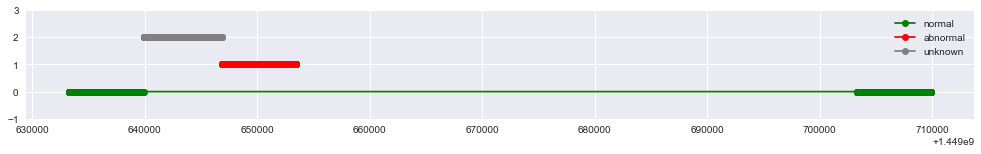

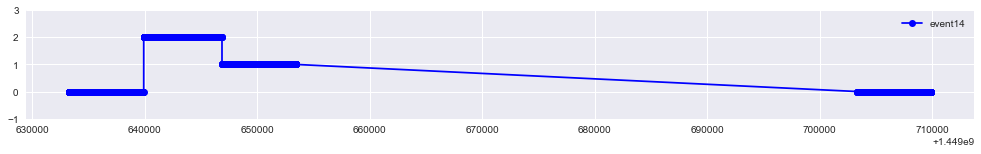

event: 15
       type  minute       hour
0    normal   982.0  16.366667
1   unknown   916.0  15.266667
2  abnormal   111.0   1.850000


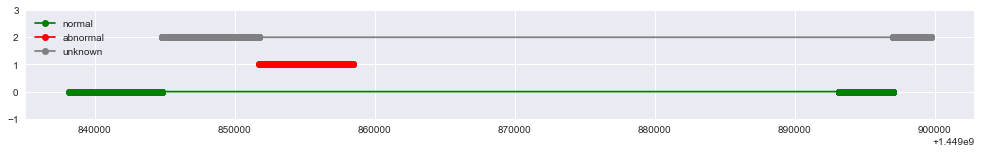

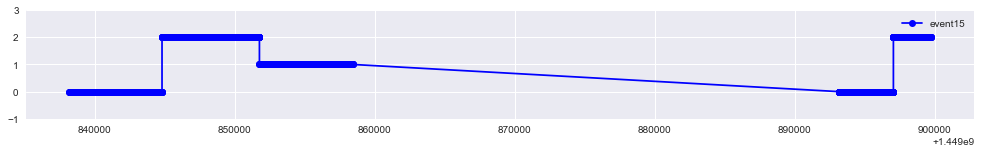

event: 16
       type  minute       hour
0    normal   610.0  10.166667
1   unknown   614.0  10.233333
2  abnormal  1451.0  24.183333


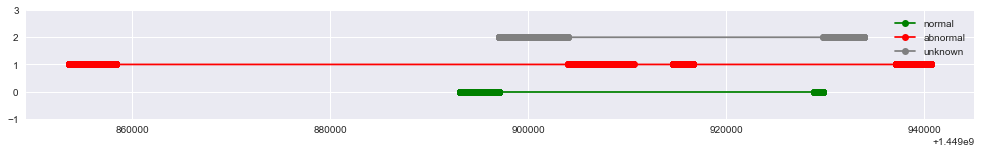

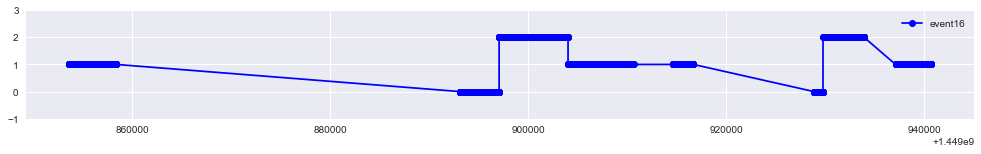

event: 17
       type  minute       hour
0    normal   915.0  15.250000
1   unknown    69.0   1.150000
2  abnormal   602.0  10.033333


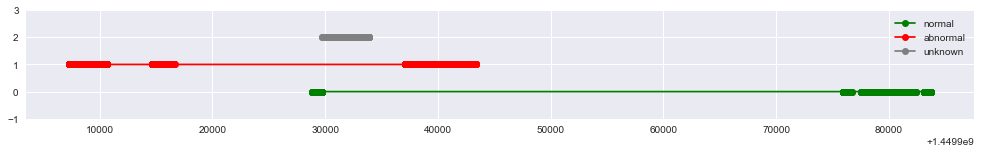

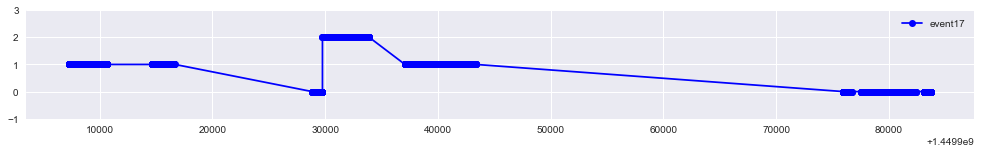

event: 18
       type  minute       hour
0    normal  1325.0  22.083333
1   unknown     0.0   0.000000
2  abnormal   250.0   4.166667


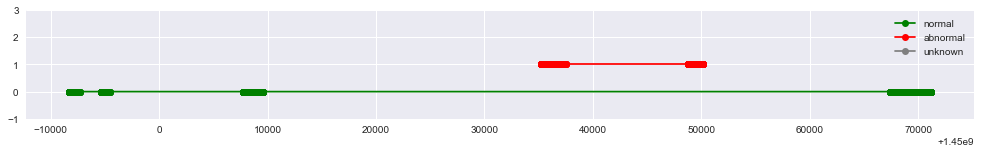

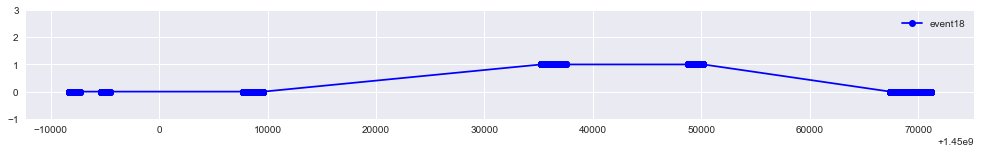

event: 19
       type  minute       hour
0    normal  1023.0  17.050000
1   unknown   116.0   1.933333
2  abnormal   111.0   1.850000


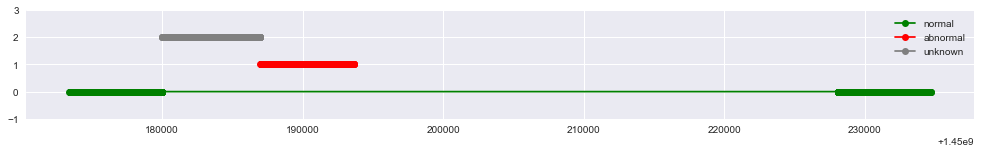

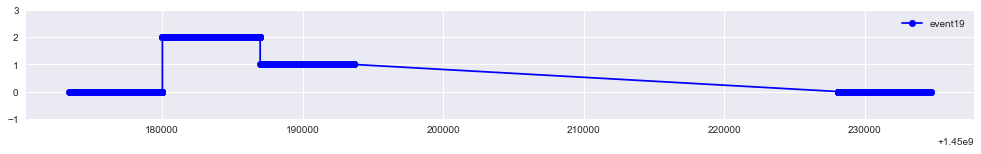

event: 20
       type  minute      hour
0    normal   481.0  8.016667
1   unknown   116.0  1.933333
2  abnormal    68.0  1.133333


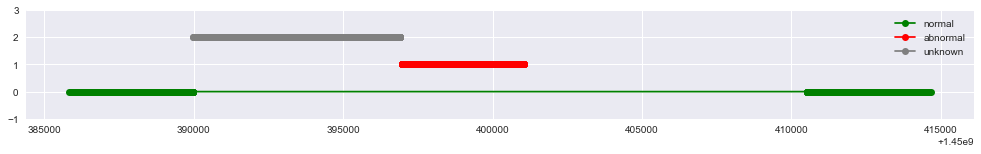

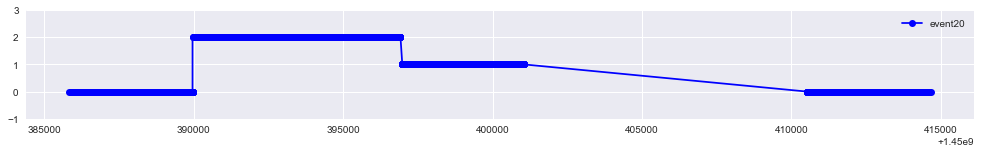

event: 21
       type  minute       hour
0    normal  1465.0  24.416667
1   unknown     0.0   0.000000
2  abnormal   117.0   1.950000


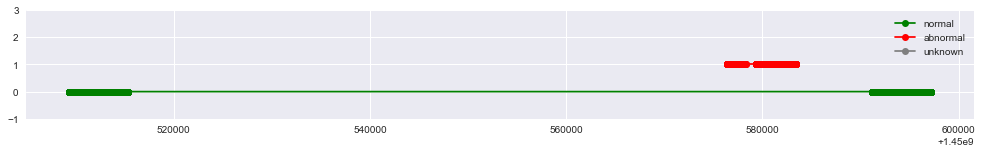

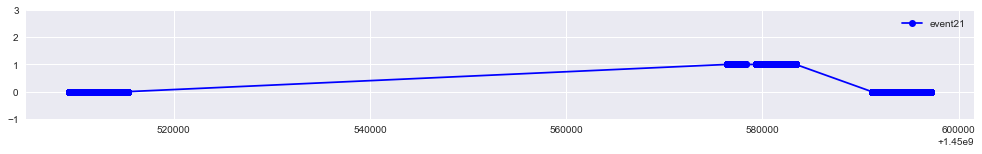

event: 22
       type  minute       hour
0    normal  1941.0  32.350000
1   unknown    95.0   1.583333
2  abnormal   110.0   1.833333


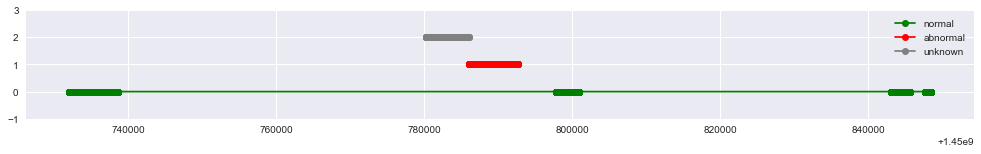

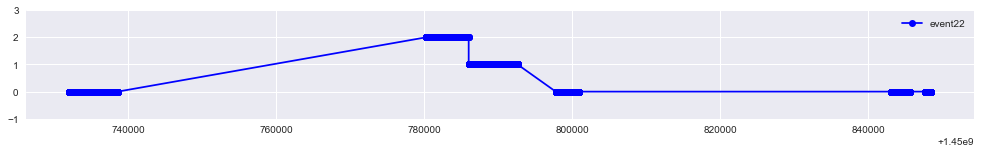

event: 23
       type  minute       hour
0    normal  1455.0  24.250000
1   unknown    18.0   0.300000
2  abnormal   110.0   1.833333


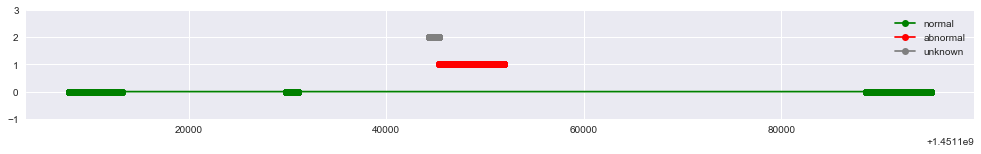

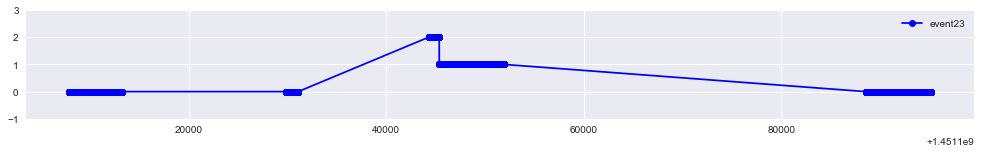

event: 24
       type  minute      hour
0    normal   111.0  1.850000
1   unknown   116.0  1.933333
2  abnormal   111.0  1.850000


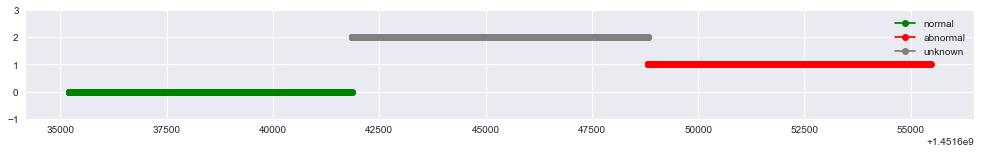

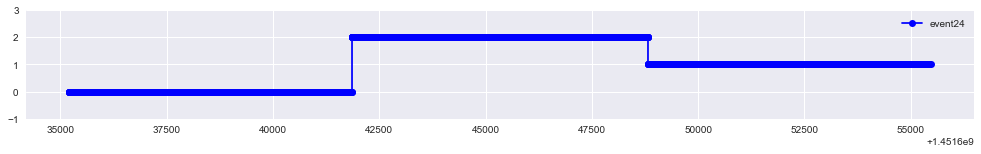

In [296]:
for eventid in set(resample_data_15['event']):
    dummy = event_info(resample_data_15,eventid)